In [1]:
SIZE = (512, 512)
CLUSTERS = 4

IMG_PATH = '../Rock-image-patches'
paths = {'Gabbro': IMG_PATH+'/Gabbro/10715B_P1_Cleaned_02_03.png',
         'Diorite': IMG_PATH+'/Diorite/11825B_P2_02_02.png',
         'Granodiorite': IMG_PATH+'/Granodiorite/11830I_P2_01_02.png',
         'Granite': IMG_PATH+'/Granite/11823G_P2_01_02.png'}

In [2]:
import os
from skimage import io, color
from PIL import Image, ImageOps
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def get_dominant_colors(img):
    reshape = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    lb = np.arange(0, len(np.unique(cluster.labels_))+1) # Get the number of different clusters
    (hist, _) = np.histogram(cluster.labels_, bins = lb) # create histogram
    hist = hist.astype("float"); hist /= hist.sum() # normalize
    colors = sorted([(percent, color) for (percent, color) in zip(hist, cluster.cluster_centers_)])
    features = []
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
    return features

def get_dominants_plot(features):
    height = SIZE[0] #50
    width = SIZE[1] #300
    rect = np.zeros((height, width, 3), dtype=np.uint8)
    start = 0
    for i in range(CLUSTERS):
        color_ = np.array(features[i*CLUSTERS:i*CLUSTERS+3])
        percent = features[i*CLUSTERS+3]
        end = start + (percent * width)
        cv2.rectangle(rect, (int(start), 0), (int(end), height), color_.astype("uint8").tolist(), -1)
        start = end
    return rect

def get_percentages(features):
    ppercents = []
    percents = []
    p = 0
    for i in range(CLUSTERS):
        p+=features[i*CLUSTERS+3]
        n = features[i*CLUSTERS+3]/2
        ppercents.append((p-n)*SIZE[1])
        if i == 0:
            percents.append(str(features[i*CLUSTERS+3]*100)[:4]+"%       ")
        else:
            percents.append(" "*(i+2)+str(features[i*CLUSTERS+3]*100)[:4]+"%")
    return (ppercents, percents)

def get_avg_plot(img):
    average = img.mean(axis=0).mean(axis=0)
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    return avg_patch

In [3]:
images = []
for path in list(paths.values()):
    img = Image.open(path).convert('RGB')
    img = np.array(ImageOps.fit(img, SIZE, Image.ANTIALIAS))
    images.append(img[...,:3])
    
extracted = [get_dominant_colors(img) for img in images]

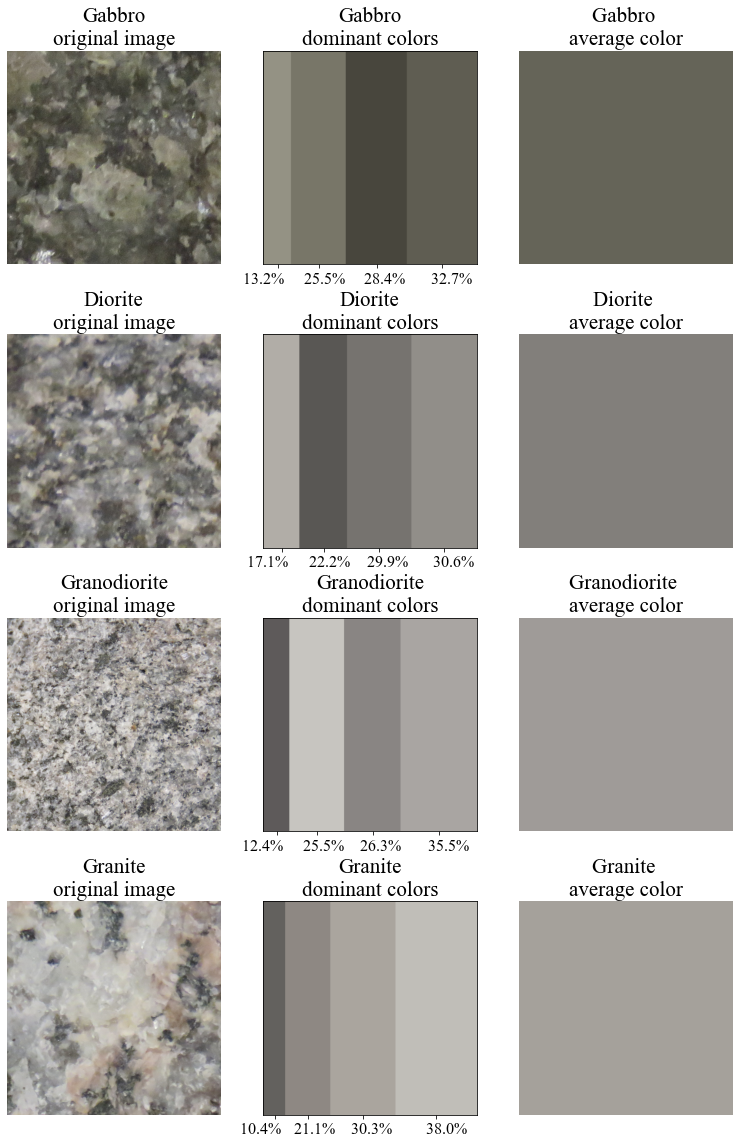

In [4]:
plot = []
tittle = []
ticks = []
rocks = list(paths.keys())

for i in range(len(images)):
    plot.append(images[i])
    plot.append(get_dominants_plot(extracted[i]))
    plot.append(get_avg_plot(images[i]))
    ticks.append([])
    ticks.append(get_percentages(extracted[i]))
    ticks.append([])
    tittle.append(rocks[i]+'\noriginal image') #\n #space
    tittle.append(rocks[i]+'\ndominant colors') #\n #space
    tittle.append(rocks[i]+' \naverage color') #\n #space

plt.rc('font', family='Times New Roman')
plt.rc('axes', titlesize=21)
plt.rc('xtick', labelsize=16)

rows = len(rocks)
columns = int(len(plot) / rows)

rows = 4
columns = 3

fig, plots = plt.subplots(rows, columns, figsize=(13,20)) #13,19.8 #13.5,19.8
for row in plots:
    for ax in row:
        ax.imshow(plot.pop(0))
        ax.set_title(tittle.pop(0))
        tt = ticks.pop(0)
        if len(tt)!=0:
            ax.set_xticks(tt[0])#tt)
            ax.set_xticklabels(tt[1], rotation=0)
            ax.set_yticks([])
        else:
            ax.axis('off')
plt.savefig('Color extraction.png', dpi=300)
plt.show(fig)